In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
from get_utils import return_ignore, get_data
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import numpy as np
from tdr import build_tdr, orth_wrt_map
import torch as th
import plot as plot

#%matplotlib qt
#%matplotlib widget
%matplotlib inline

In [2]:
base_dir = os.path.join(os.path.expanduser('~'),'Documents','Data','MotorNet')
save_fig = os.path.join(os.path.expanduser('~'),'Dropbox (Personal)','MotorSavings','paper','figures_raw')

In [3]:
loss_type = 'lateral'
n_model = 40 # number of simulated networks

In [ ]:
N_idx = 16
F_idx = 59

T = pd.DataFrame()

for s in [128]:
    print(f'Network size: {s}')
    network_siz = s
    folder_name = f'Sim_fixed_{network_siz}'
    ignore = return_ignore(folder_name,n_model) # sometimes some of cpus fail so we want to ignore those models


    for mn in range(n_model):
        model_name = "model{:02d}".format(mn)
        if mn in ignore:
            continue

        # 1. Load data
        U = get_data(folder_name,model_name,n_hidden=network_siz)

        for N_idx in [16]:
            data = []
            force = []
            for i in range(len(U)):
                data.append(np.array(U[i]['all_hidden'])[:,int(N_idx),:])
                force.append(np.array(U[i]['endpoint_force'])[:,F_idx,:])

            # 1 build TDR
            combined_N = np.vstack(data)
            mean_N = np.mean(combined_N, axis=0)

            X = force[0] # NF1 force 
            N = data[0]-mean_N # NF1 hidden activity

            tdr = build_tdr(X,N)

            # 2 uniform shift from NF1 to FF1
            us = np.mean(data[1]-data[0],axis=0).reshape(-1,1)
            us_orth, us_orth_norm = orth_wrt_map(us,tdr)
            

            # 2.1 Baseline FF1
            _, loss_np = get_data(folder_name,model_name,{'NF1':[0]},[8],n_hidden=network_siz,return_loss=True) 
            loss_ff1 = loss_np[0][loss_type].mean()

            # 3. perturb hidden
            for mag in np.linspace(-2,2,5): # positive and negative perturbation
                d_hidden = th.from_numpy(mag*us_orth.T)

                # now lets perturb or not and calculate the saving in behavior
                _, loss_p = get_data(folder_name,model_name,{'NF2':[0]},[8],n_hidden=network_siz,disturb_hidden=True,t_disturb_hidden=N_idx/100,d_hidden=d_hidden,return_loss=True)

                loss_ff2 = loss_p[0][loss_type].mean()

                d = {'size':[network_siz]*2,'N':[N_idx]*2,'m':[mn]*2,'loss':[loss_ff1,loss_ff2],'phase':['FF1','FF2'],'mag':[0,mag]}
                T = pd.concat([T,pd.DataFrame(d)],ignore_index=True)

T.to_csv(base_dir+'/perturb.csv',index=False)

# plot

(32.0, 36.0)

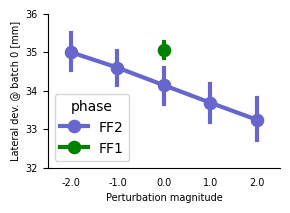

In [5]:
T = pd.read_csv(base_dir+'/perturb.csv')
filter_condition = (
    (T['size'] == 128) # (T['mag'].isin([-1,-0.5,0,0.5,1])) &
)
T = T[filter_condition].reset_index(drop=True)
T.loss = T.loss*1000


# Plotting
ax = plot.my_pointplot(T,x='mag',y='loss',hue='phase',figsize=(3, 2),linewidth=3,xlabel='Perturbation magnitude',ylabel='Lateral dev. @ batch 0 [mm]')
ax.set_ylim([32, 36])
# fig.savefig(os.path.join(save_fig,'perturbation.pdf'),dpi=300,bbox_inches='tight')

In [ ]:
# T = pd.read_csv(base_dir+'/perturb3.csv')

# filter_condition = (
#     (T['phase'] == 'FF2'))
# T = T[filter_condition].reset_index(drop=True)
# T
# sb.pointplot(x='N', y='loss', data=T,hue='mag') #,errorbar=None